In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps

import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing, equ2gal

from qubic.lib.MapMaking.Qmaps import InputMaps

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockColumnOperator, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline 

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

300


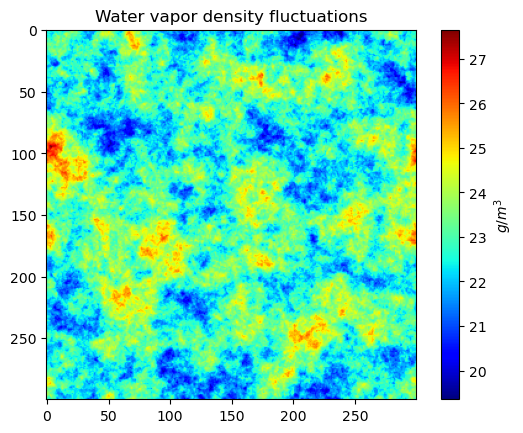

In [4]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
plt.imshow(wv_fluctuations, cmap='jet')
plt.title('Water vapor density fluctuations')
plt.colorbar(label=r'$g/m^{3}$')

In [5]:
atm.frequencies

array([132.92014967, 136.30295415, 139.77185066, 143.32903024,
       146.97673968, 150.71728296, 154.5530227 , 158.48638163,
       162.51984414, 166.65595787, 194.94955285, 199.91099941,
       204.9987143 , 210.21591101, 215.56588487, 221.05201501,
       226.67776663, 232.44669305, 238.36243807, 244.42873822])

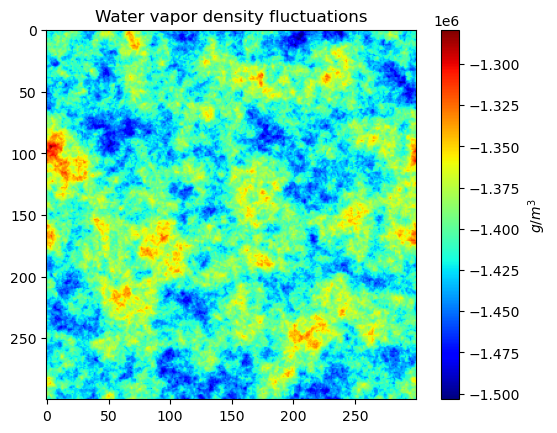

In [6]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], wv_fluctuations.shape[1], 3))
temp_fluctuations[..., 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[..., 0] -= np.mean(temp_fluctuations[:, 0])

plt.imshow(temp_fluctuations[..., 0], cmap='jet')
plt.title('Water vapor density fluctuations')
plt.colorbar(label=r'$g/m^{3}$')

316.44761928968586 -58.75808063333319


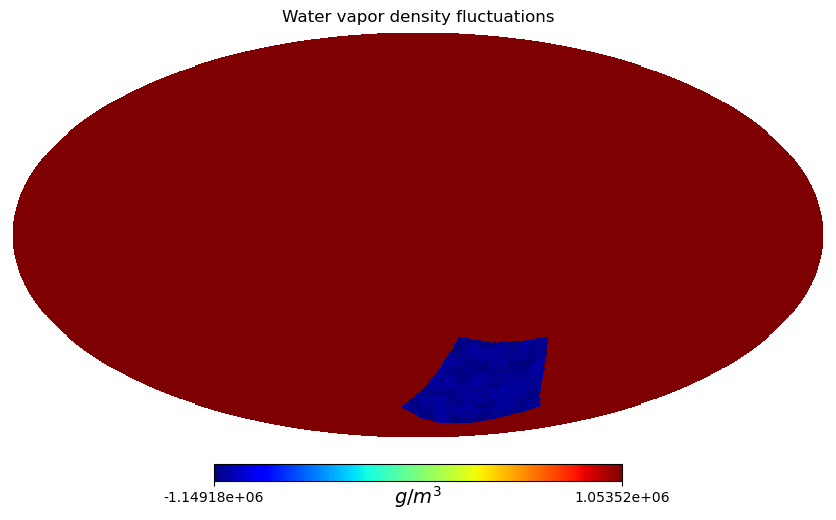

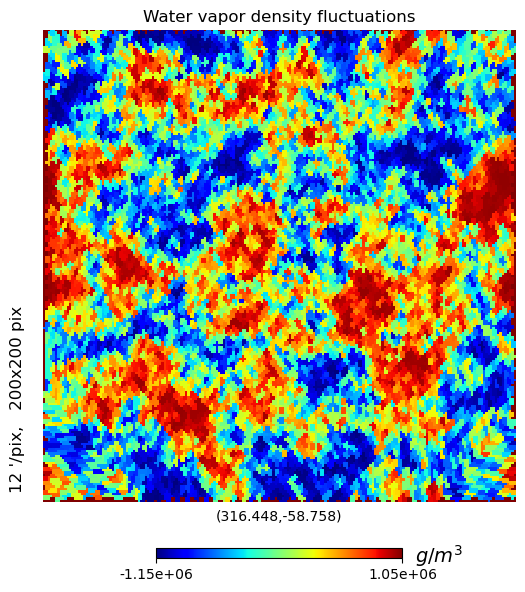

In [7]:
healpy_temp_fluctuations = np.zeros((hp.nside2npix(params['nside']), 3))
healpy_temp_fluctuations[..., 0] = atm.get_healpy_atm_maps_2d(atm.get_temp_maps(wv_fluctuations))[0]
index = np.where(healpy_temp_fluctuations!=0)
healpy_temp_fluctuations[index, 0] -= np.mean(healpy_temp_fluctuations[index, 0])
min = np.min(healpy_temp_fluctuations[index, 0])
max = np.max(healpy_temp_fluctuations[index, 0])

hp.mollview(healpy_temp_fluctuations[..., 0], min=min, max=max, norm='hist', cmap='jet', unit=r'$g/m^{3}$', title='Water vapor density fluctuations')
hp.gnomview(healpy_temp_fluctuations[..., 0], min=min, max=max, rot=equ2gal(0, -57), norm='hist', reso=12, cmap='jet', unit=r'$g/m^{3}$', title='Water vapor density fluctuations')

In [8]:
q_instrument = QubicInstrument(qubic_dict)
q_sampling = get_pointing(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.


In [9]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info DESKTOP-5T6UOML: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [10]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(healpy_temp_fluctuations).ravel()

Info DESKTOP-5T6UOML: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [11]:
H = R_qubic(H_qubic)
invN = invN_qubic
d = d_qubic

In [12]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = healpy_temp_fluctuations*0
true_maps = healpy_temp_fluctuations

In [13]:
stacked_dptdp_inv = np.zeros((len(H.operands),12*params['nside']**2))
for i in range(len(H.operands)):
    H_single = H
    D = H_single.operands[2]
    P = H_single.operands[-1]
    sh = P.matrix.data.index.shape
    no_det = 992
    point_per_det = int(sh[0] / no_det)
    
    mapPtP_perdet_seq = np.zeros((no_det,12*params['nside']**2))
    
    for det in range(no_det):
        mapPitPi = np.zeros(12*params['nside']**2)
        for peak in range(sh[1]):
            for sample in range(det*point_per_det, (det+1)*point_per_det):
                mapPitPi[P.matrix.data.index[sample,peak]] += P.matrix.data.r11[sample,peak]**2
        mapPtP_perdet_seq[det,:] = mapPitPi

    D_elements = D.data
    D_sq = D_elements**2
    mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
    dptdp = mapPtP_seq_scaled.sum(axis = 0)
    dptdp_inv = 1 / dptdp
    dptdp_inv[np.isinf(dptdp_inv)] = 0.
    stacked_dptdp_inv[i] = dptdp_inv
preconditioner = BlockDiagonalOperator( \
            [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
            new_axisin=0)

In [ ]:
stacked_dptdp_inv_bis = np.zeros((len(H.operands), 12*params['nside']**2))
no_det = 992

for i in range(len(H.operands)):
    H_single = H
    D = H_single.operands[2]
    P = H_single.operands[-1]
    sh = P.matrix.data.index.shape
    point_per_det = int(sh[0] / no_det)
    
    mapPtP_perdet_seq_bis = np.zeros((no_det, 12*params['nside']**2))
    
    # Vectorized inner loops while preserving original computation order
    for det in range(no_det):
        det_start = det * point_per_det
        det_end = (det + 1) * point_per_det
        indices = P.matrix.data.index[det_start:det_end]
        values = P.matrix.data.r11[det_start:det_end]
        mapPitPi = np.zeros(12*params['nside']**2)
        for peak in range(sh[1]):
            np.add.at(mapPitPi, indices[:, peak], values[:, peak]**2)
        mapPtP_perdet_seq_bis[det] = mapPitPi

    D_elements = D.data
    D_sq = D_elements**2
    mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq_bis 
    dptdp = mapPtP_seq_scaled.sum(axis=0)
    dptdp_inv = 1 / dptdp
    dptdp_inv[np.isinf(dptdp_inv)] = 0.
    stacked_dptdp_inv_bis[i] = dptdp_inv

preconditioner = BlockDiagonalOperator(
    [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv_bis],
    new_axisin=0)


In [15]:
print(np.array_equal(mapPtP_perdet_seq, mapPtP_perdet_seq_bis))
print(np.array_equal(stacked_dptdp_inv, stacked_dptdp_inv_bis))

False
False


In [16]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-15,
    maxiter=200,
    disp=True,
    M=M.operands[0],
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

NameError: name 'M' is not defined

Text(0, 0.5, 'Convergence')

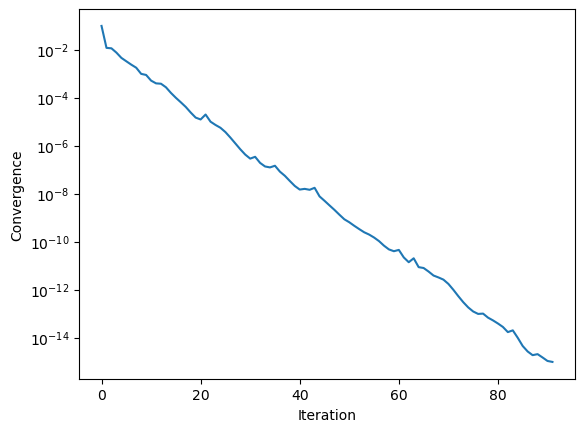

In [ ]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

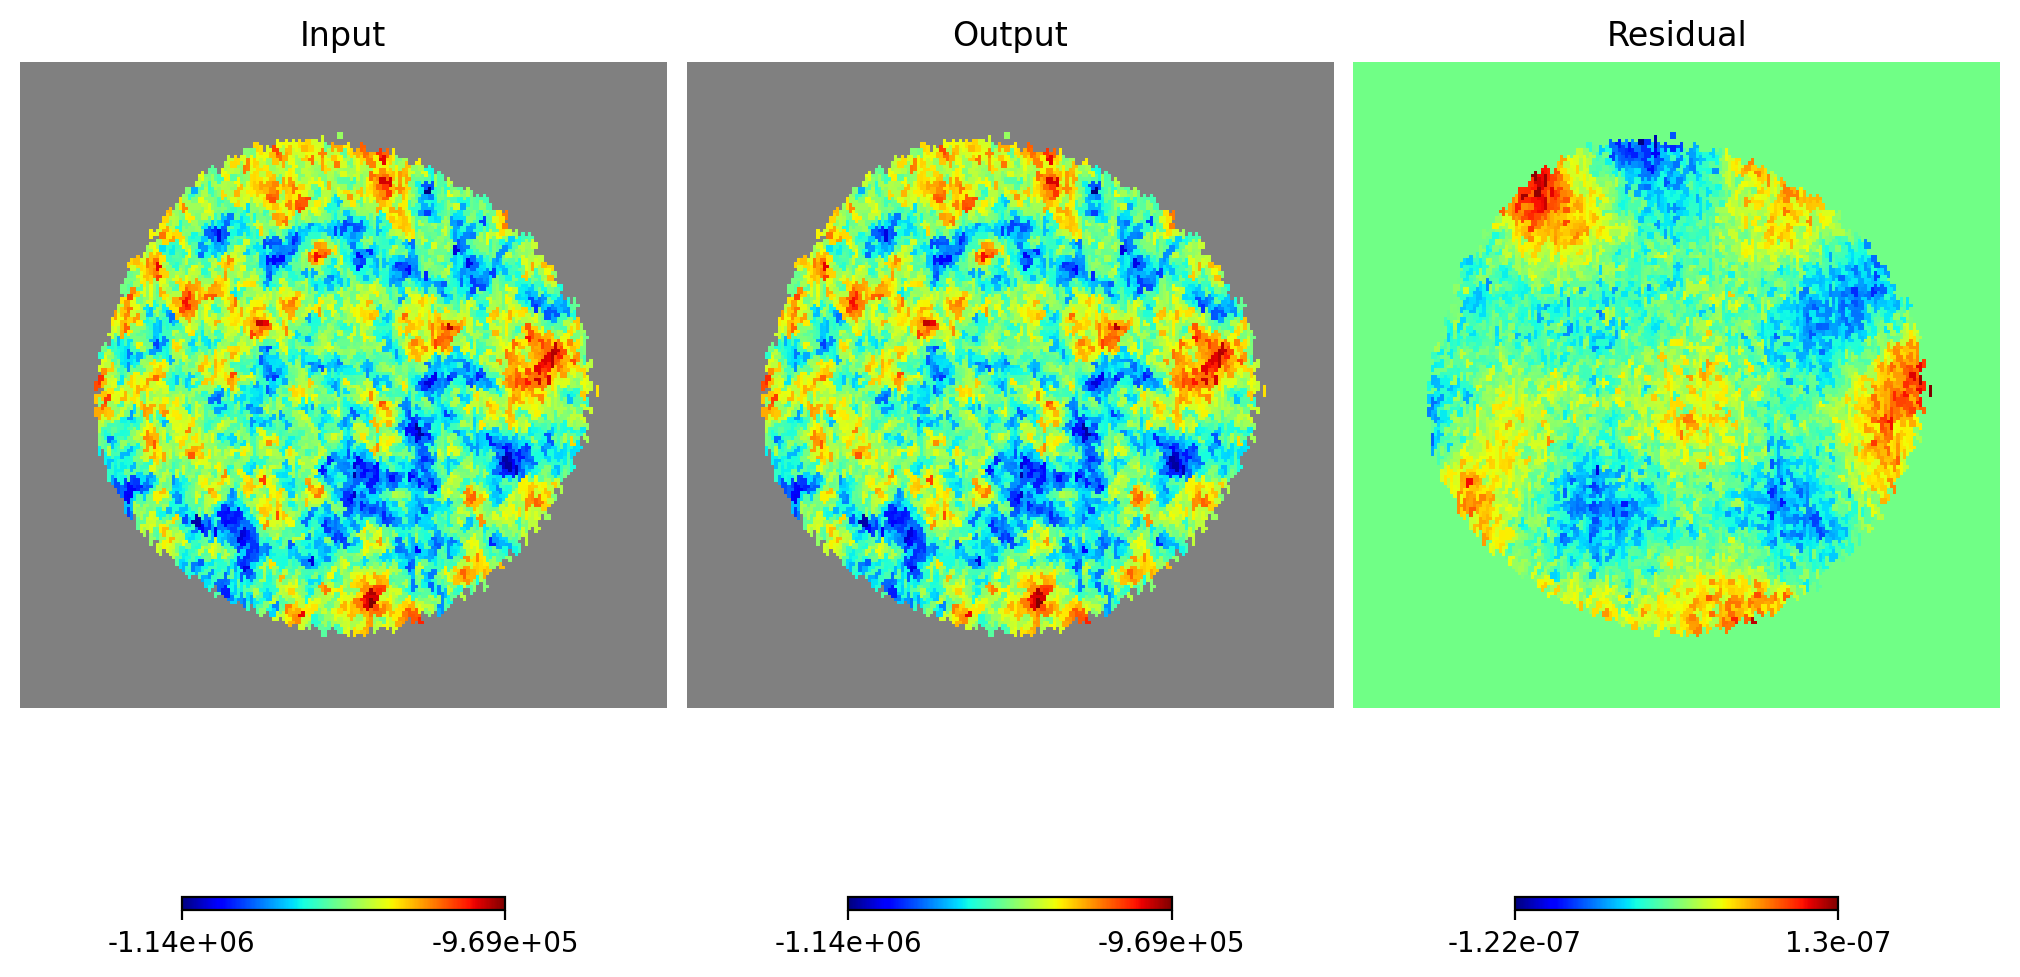

In [ ]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

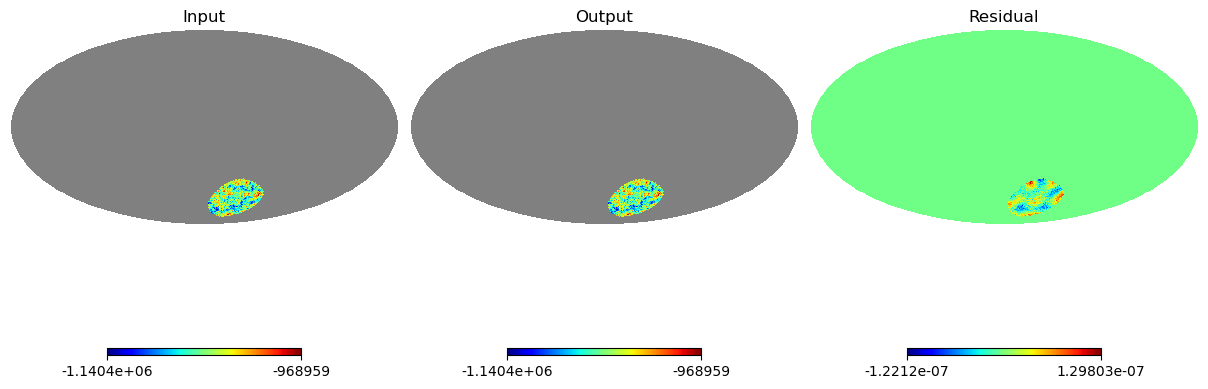

In [ ]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

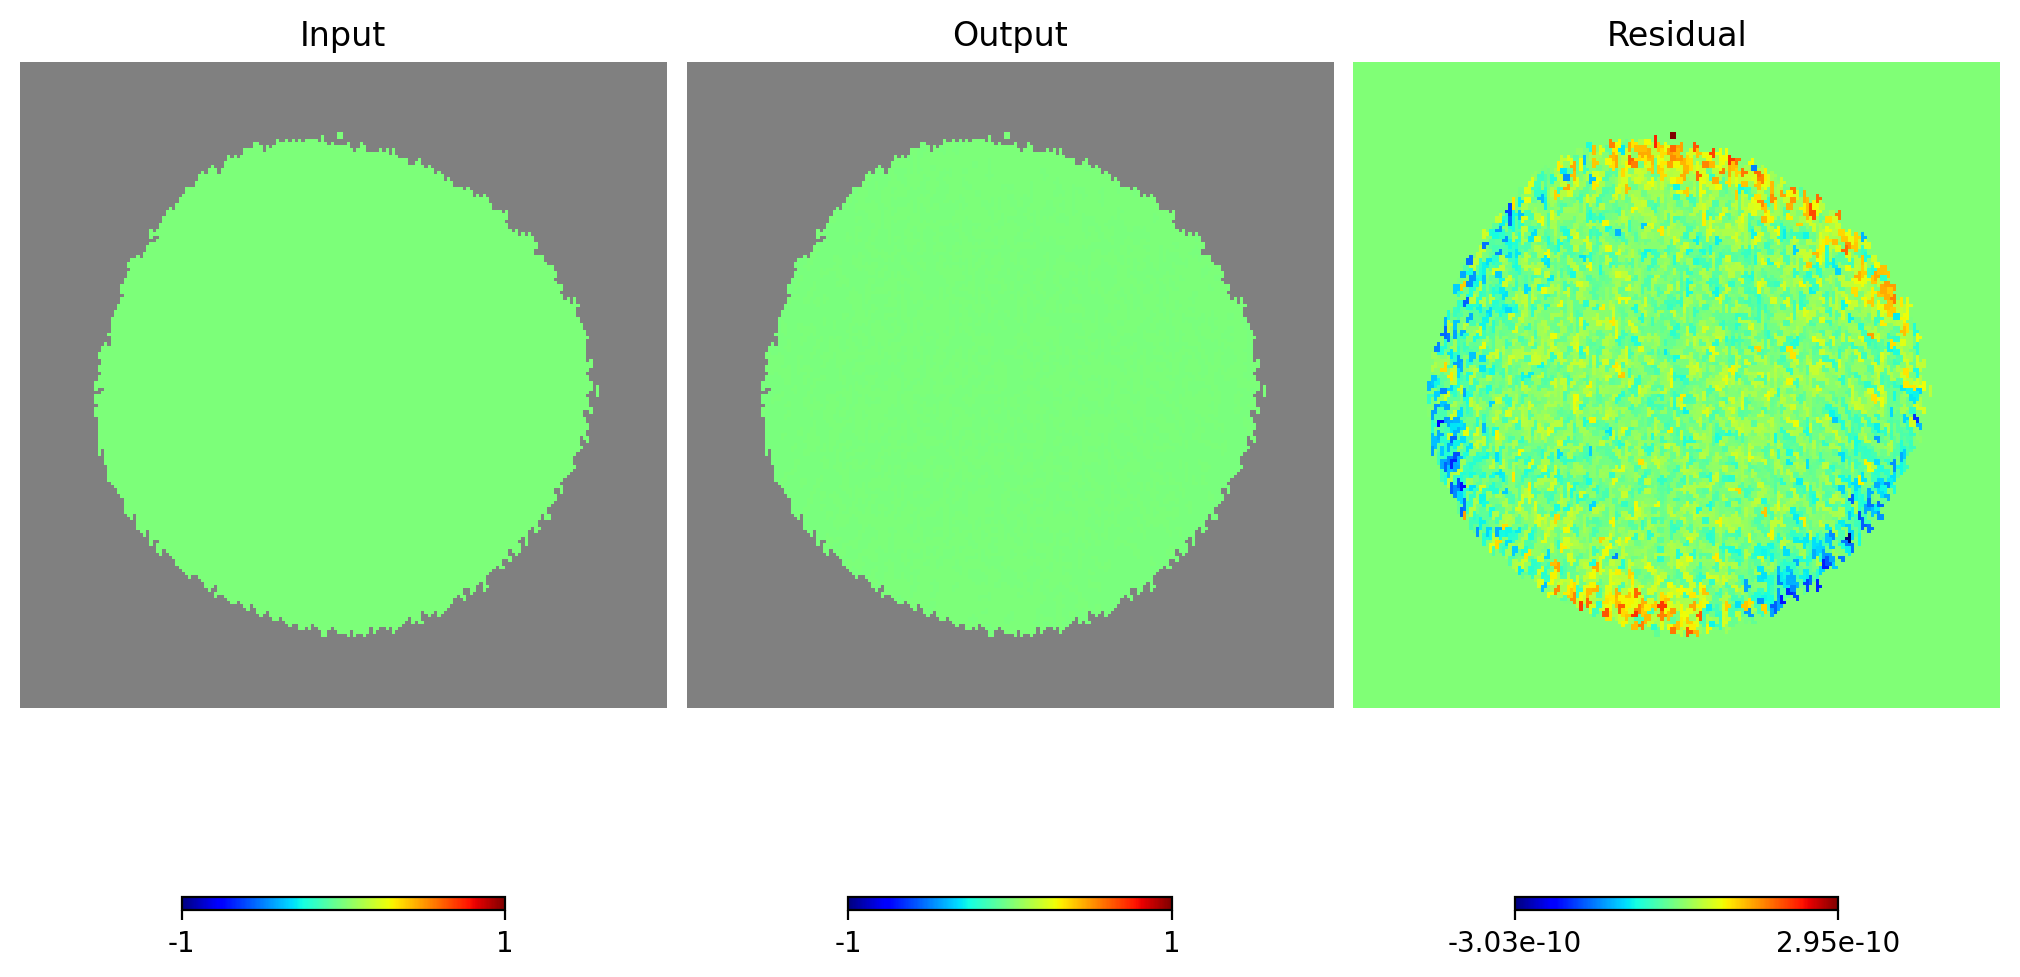

In [ ]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3